The nv center paper https://pubs.aip.org/avs/aqs/article/2/2/024701/997281/Introduction-to-quantum-optimal-control-for has an example of a control pulse for just the zeeman term of the Hamiltonian.  I want to replicate this and put it in GRAPE to try to understand how to deal with the B-field being aligned or not aligned with the NV-axes.

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from scipy.constants import physical_constants, h
from dataclasses import dataclass

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

The following cells are to write the Hamiltonian using the rotating wave approximation

In [2]:
#defining constants in hamiltonian
h= 6.582119 * 1e-16 #eV * sec 
Bperpendicular = 10 #mT
Bparallel = 10 #mT
gammanv = 2*np.pi*28 * 1000000 #Hz/mT
omeganv = Bparallel * gammanv
omegamw = 1000000000 #Hz
Delta = omeganv - omegamw
#Delta
Omega = Bperpendicular * gammanv
Omega

1759291886.0102842

In [3]:
h=1
H0= h*Delta*sigmaz() + h*sigmax() + h*sigmay()
#H0 = h*Delta*sigmaz()
H0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 7.59291886e+08+0.j  1.00000000e+00-1.j]
 [ 1.00000000e+00+1.j -7.59291886e+08+0.j]]

In [4]:
R = 100
H_ops = [Omega*sigmax(), Omega*sigmay()]

#Labels for the graph
H_labels = [r'$u_{x}$',
            r'$u_{y}$',]

In [5]:
#writing out starting state for single qubit

psi0 = basis(2, 0)
print (psi0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]


In [6]:
#creating transform matrix

phi=((1)*np.pi)
U = 1*rx(phi)
#U = sigmax()
U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]

In [7]:
#me_result = mesolve(result.H_t, startingstate, times, c_ops, e_ops,options=Options(nsteps=10000000))

In [30]:
#definiting U0 ??????
T = 1/100000000000
times = np.linspace(0, T, 5000)
u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])
u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

In [ ]:
#doing GRAPE!
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time: 561.77s. Est. time left: 00:01:24:15
20.0%. Run time: 1144.61s. Est. time left: 00:01:16:18
30.0%. Run time: 1715.21s. Est. time left: 00:01:06:42


In [ ]:
#Plotting pulse sqeuences from GRAPE
plot_grape_control_fields(times, result.u[:,:,:] / (2 * pi), H_labels, uniform_axes=True);

In [23]:
startingstate = Qobj([[1.],
                      [0.]])
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.89579344-0.30401035j  0.22509596+0.23337444j]
 [-0.22509596+0.23337444j -0.89579344+0.30401035j]]

In [24]:
finalstate = result.U_f*startingstate
finalstate

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.89579344-0.30401035j]
 [-0.22509596+0.23337444j]]

In [25]:
finalstateideal = U*startingstate
finalstateideal

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.+0.j]
 [0.-1.j]]

In [26]:
#c_ops = []
#e_ops = [sigmax(), sigmay(), sigmaz()]
#U_f_numerical = propagator(result.H_t, times, c_ops, args={})
#me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)
b = Bloch() 

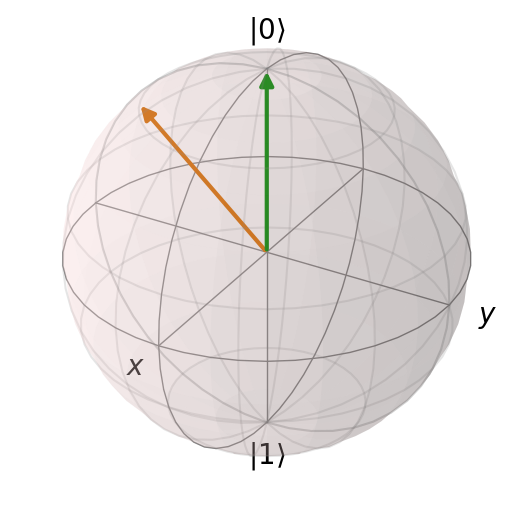

In [27]:
#plotting bloch sphere

#b.add_points(me_result.expect)
b.add_states(startingstate)
b.add_states(finalstate)
b.show()

In [16]:
c_ops = []
e_ops = [sigmax(), sigmay(), sigmaz()]
me_result = mesolve(result.H_t, startingstate, times, c_ops, e_ops)
b = Bloch()

b.add_points(me_result.expect)

b.add_states(startingstate)
b.add_states(U * startingstate)
b.render()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\_ode.py:1011: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [17]:
len(times)

100

In [18]:
me_result.expect

NameError: name 'me_result' is not defined

In [20]:
me_result = mesolve(result.H_t, startingstate, times, c_ops, e_ops,options=Options(nsteps=1e8))

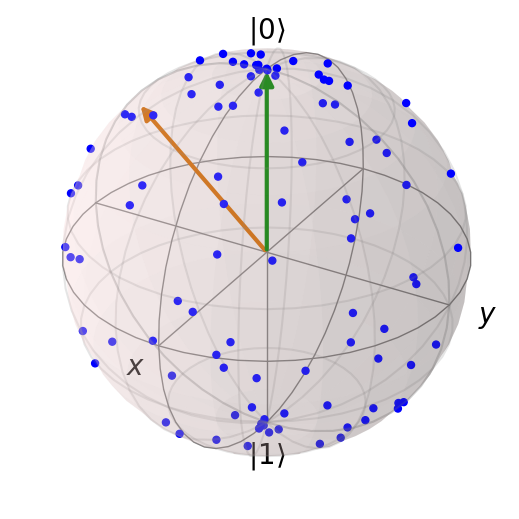

In [29]:
b = Bloch()

b.add_points(me_result.expect)

b.add_states(startingstate)
b.add_states(finalstate)
b.render()
b.show()